**EEGBCI Sensorimotor Dynamics - within‑subject motor ERD & ERP analysis**

Dataset: MNE-EEGBCI, Subject 3, run 3 (open and close left or right fist)

This is an independent analysis of a selected subject and run under the MNE-EEGBCI Motor Movement/Imagery Dataset, with added commentary explaining rationale and my reasoning process.

I initially formulated two working hypotheses to guide the analysis:

H1: Real hand movement (T1/T2) should cause stronger brain rhythm suppression in motor areas (mu/beta ERD) than rest (T0). Tested by comparing ERSPs for movement vs rest over motor areas (C3/C4).

H2: Motor ERPs should peak 200–500 ms after movement and be bigger on the opposite side of the moving hand (contralateral). Tested by measuring ERP peak timing and amplitude at C3/C4 and comparing contralateral vs ipsilateral.

**Dataset description**

Participants: 109 healthy subjects

Runs per subject: 14

Current selection: Subject 3, run 3

Condition: Open and close left or right fist

The dataset originates from the EEG Motor Movement/Imagery Dataset hosted on PhysioNet:
https://physionet.org/content/eegmmidb/1.0.0/


**Methods:**

1. Data Loading / setup

2. Visualization & QC: Raw EEG visualization and power spectral density assessment

3. Preprocessing: 60 Hz notch filtering, downsampling to 120 Hz

4. ICA: Independent Component Analysis (ICA), artifact removal

5. Epoching: Segmentation into rest (T0), left-hand (T1), and right-hand (T2) movement epochs (-0.2 to 1.0 s)

6. ERSP / ERD Analysis: Morlet wavelet transform to quantify mu/beta (8-30 Hz) ERD

7. ERP Analysis: Evoked potential extraction and contralateral/ipsilateral comparisons

**1. Load / Setup**

Initializing the analysis environment and loading subject 3, run 3 data.

In [1]:
# EEG data analysis framework
!pip install mne

# Main imports
import mne
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Display plots directly in notebook
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 44.7 MB/s eta 0:00:00


In [2]:
# Dataset utilities
from mne.datasets import eegbci
from mne.io import read_raw_edf
from mne.preprocessing import ICA

# Choosing subject and run
subject = 3
runs = [3]

# Setting path
my_path = '/root/mne_data'
path = eegbci.load_data(subject, runs, path=my_path, force_update=False, update_path=False)

Download complete in 07s (2.5 MB)


In [3]:
raw = read_raw_edf(path[0], preload=True)

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [4]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>

**2. Visualization & Quality Control QC**

(raw.plot, PSD, initial observation)

Initial data inspection via raw voltage traces and power spectral density (PSD).

Using matplotlib as 2D backend.


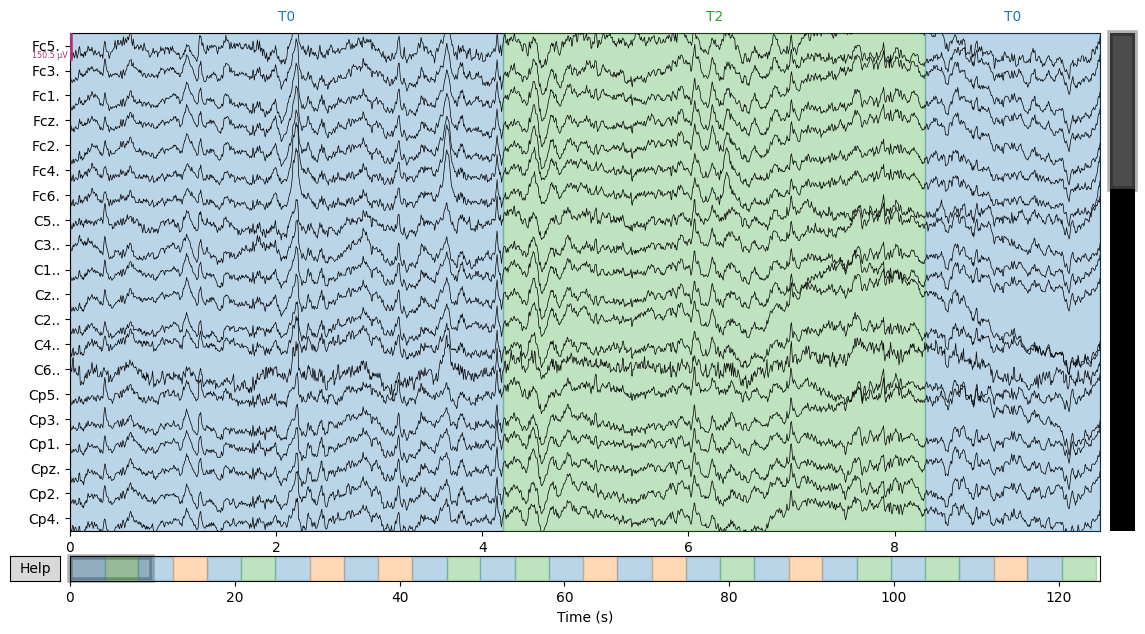

In [5]:
fig = raw.plot(scalings='auto', show=False)
fig.set_size_inches(12, 6)
plt.show()

Voltage values (µV) for each channel on the y-axis, channel on x-axis. This is for quality control and confirming data is loaded properly.

Event anotation mapping:

In [6]:
raw.annotations

<Annotations | 30 segments: T0 (15), T1 (7), T2 (8)>

Based on the dataset description, from the annotations we can determine that:

T0 corresponds to rest

T1 corresponds to onset of motion - left fist

T2 corresponds to onset of motion - right fist

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


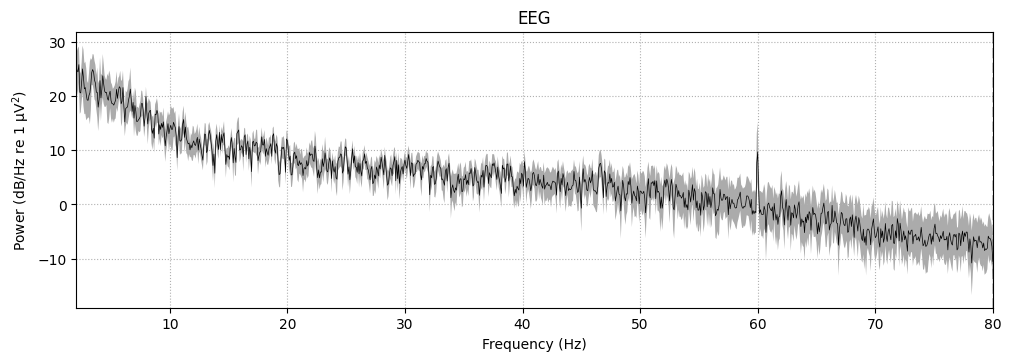

In [7]:
raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=80, average=True, spatial_colors=False);

**3. Preprocessing**

(filtering, downsampling)

I apply a 60 Hz notch filter to remove power-line noise:

In [8]:
raw.notch_filter(freqs=60)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)



<RawEDF | S003R03.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


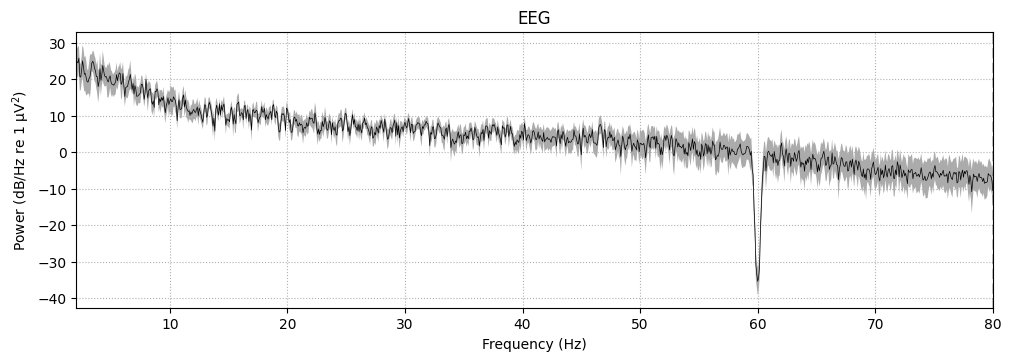

In [9]:
raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=80, average=True, spatial_colors=False);

To make later analyses more computationally efficient, I downsample the data from 160 Hz down to 120 Hz.

In [10]:
raw.resample(120, npad='auto')

<RawEDF | S003R03.edf, 64 x 15000 (125.0 s), ~7.4 MiB, data loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 17.067 (s)
Plotting power spectral density (dB=True).


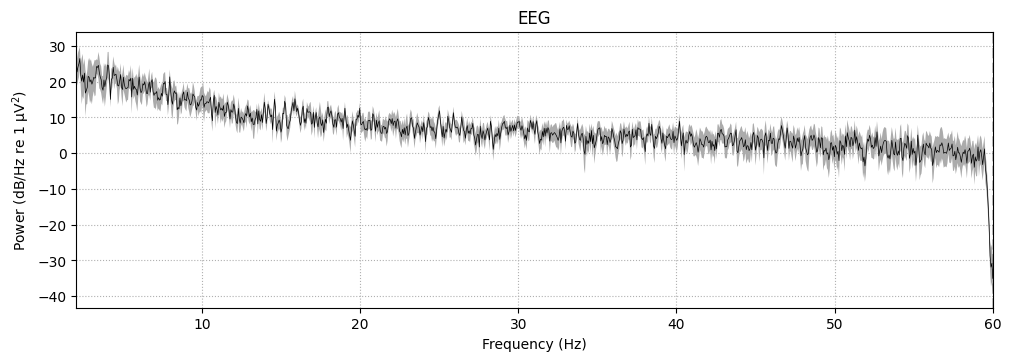

In [11]:
raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=60, average=True, spatial_colors=False);

**4. ICA & Component Inspection**

(Montaging, artifact analysis & removal)

Assigning 3D spatial arrangement of electrodes on standard 10–20 system, for location context in topographic plotting:

In [12]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.rename_channels(mapping= lambda name: name.replace(".",""))
raw.set_montage(montage, match_case=False)

<RawEDF | S003R03.edf, 64 x 15000 (125.0 s), ~7.4 MiB, data loaded>

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 397 samples (3.308 s)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.2s.


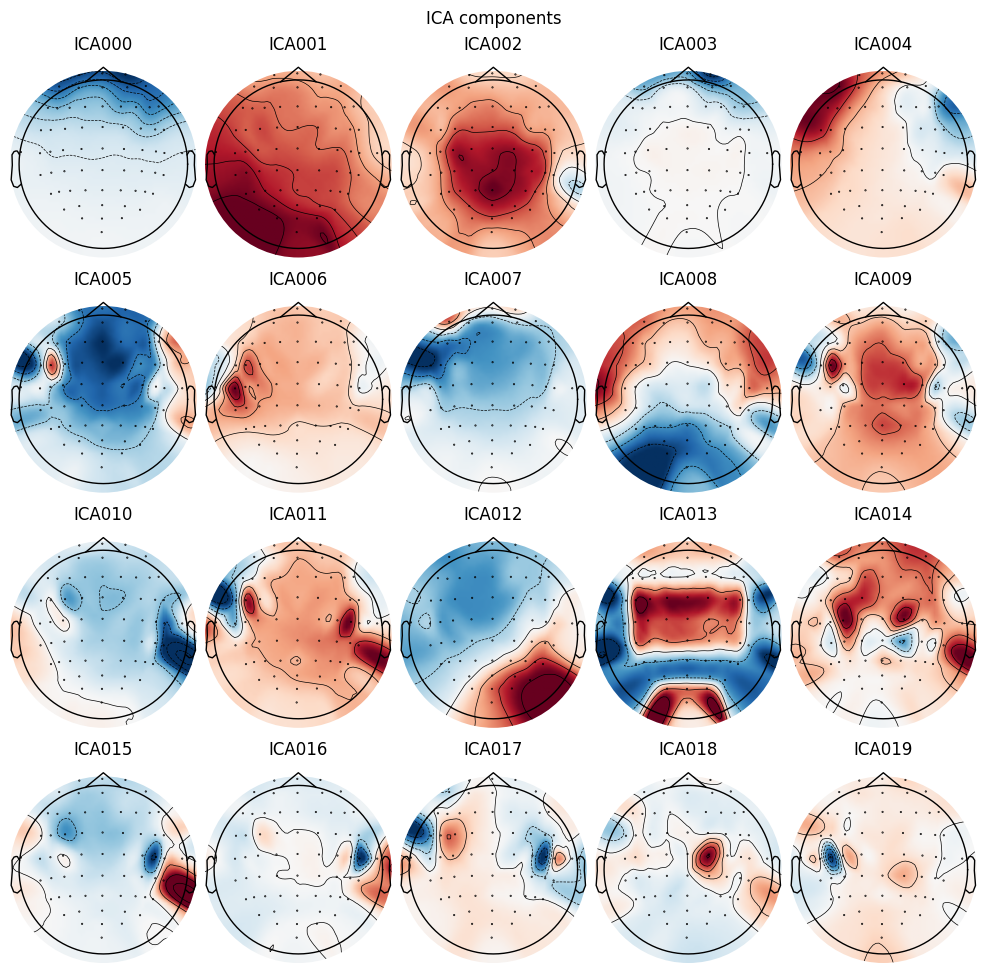

<Figure size 640x480 with 0 Axes>

In [13]:
# Duplicate of "raw", with 1 Hz filter, for learning the ICA model
raw_for_ica = raw.copy().filter(l_freq=1., h_freq=None)

# ICA object
ica_20 = ICA(
    n_components=20,
    method='fastica',
    random_state=97
)

# ICA fitted on high-pass duplicate
ica_20.fit(raw_for_ica)

ica_20.plot_components();

plt.tight_layout()
plt.show()

1 Hz high-pass filter was applied to remove low-frequency noise below ~1 Hz, making the EEG signal more stationary so ICA is able to more reliably identify independent components corresponding to physiological artifacts (e.g., eye blinks, muscle activity) rather than slow noise.

Frequencies above 1 Hz were preserved (e.g., theta 4 Hz to beta 30–40 Hz, relevant for motor analysis).


Creating RawArray with float64 data, n_channels=20, n_times=15000
    Range : 0 ... 14999 =      0.000 ...   124.992 secs
Ready.


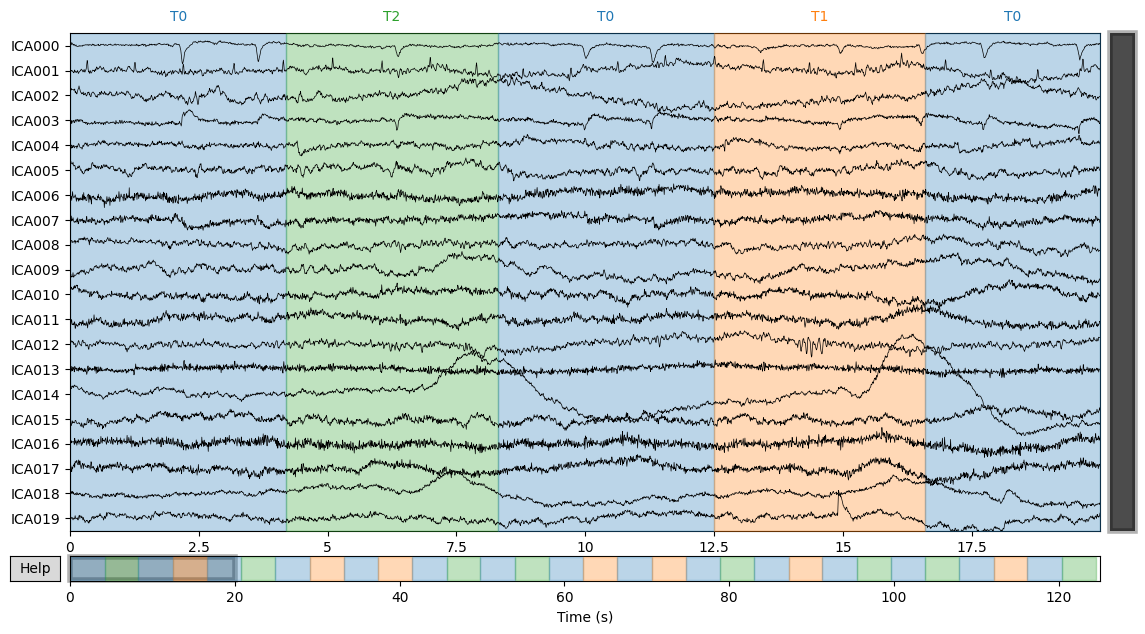

In [14]:
sources = ica_20.plot_sources(raw, show=False)
sources.set_size_inches(12, 6)
sources.show()

Projecting the raw EEG through the ICA model to see how each independent component behaves over time.

The ICA model ica_20 provides the components (spatial patterns and mixing matrix).

raw provides the data that those components are projected onto.

I will now be plotting each ICA component topographically for thorough analysis:

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated


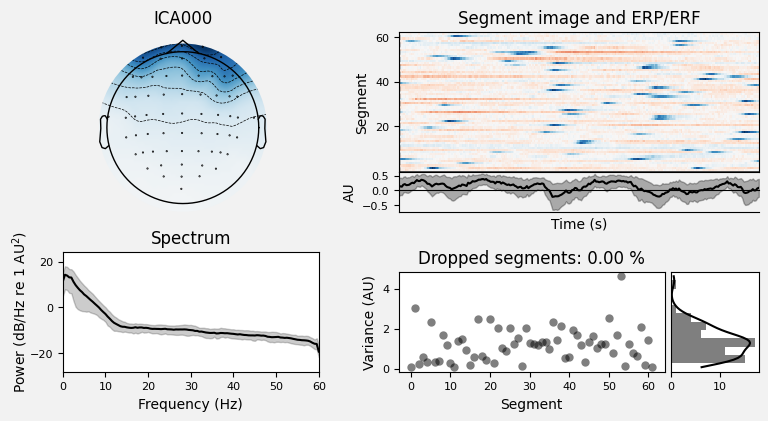

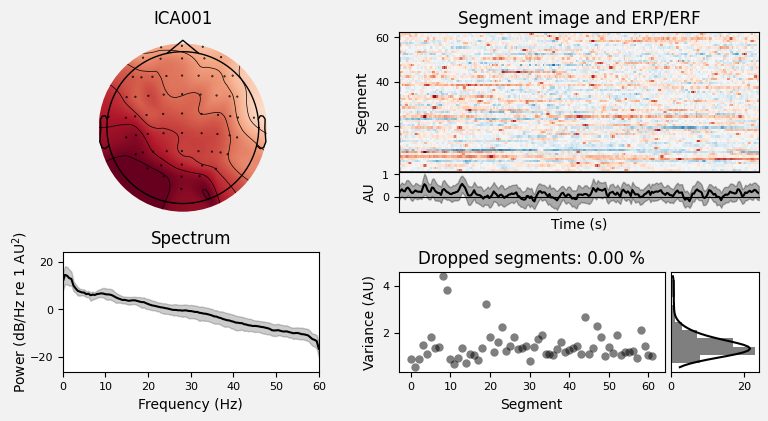

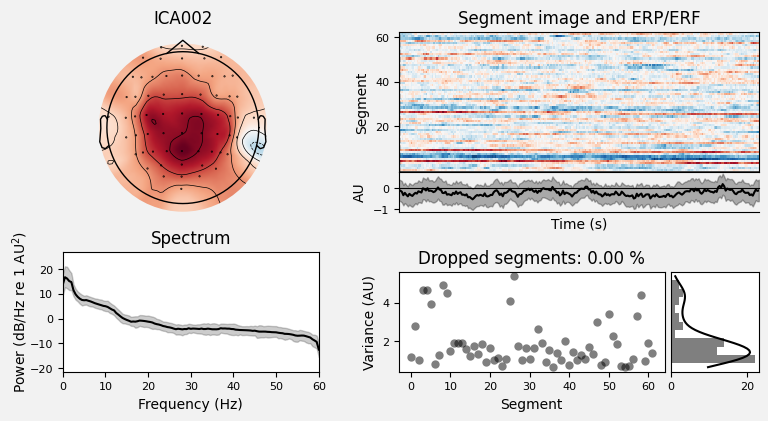

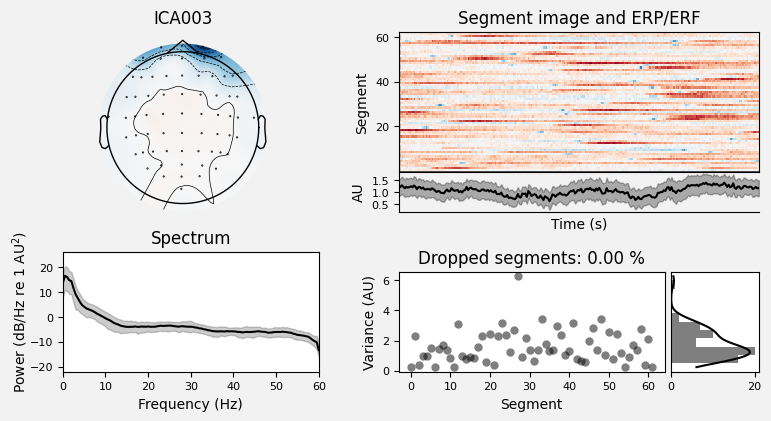

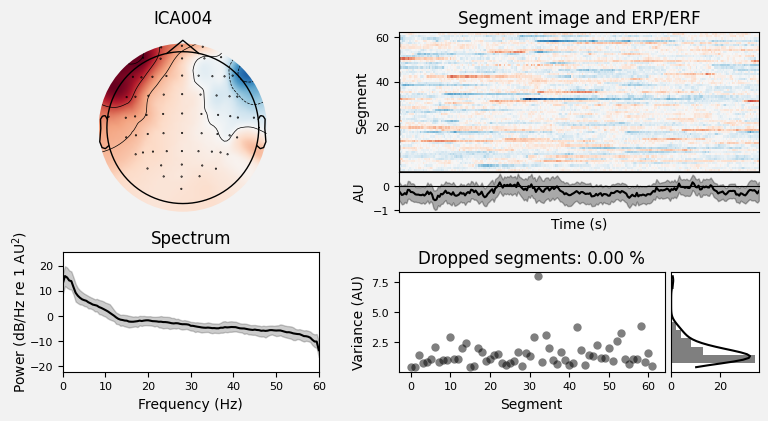

[<Figure size 800x400 with 6 Axes>,
 <Figure size 800x400 with 6 Axes>,
 <Figure size 800x400 with 6 Axes>,
 <Figure size 800x400 with 6 Axes>,
 <Figure size 800x400 with 6 Axes>]

In [15]:
ica_20.plot_properties(raw, picks=range(0,5), figsize=(8,4))

My reasoning for artifact exclusion is to only exclude them only when there is strong evidence that they reflected non-neural sources, and for components I am uncertain I will retain in order to preserve neural signal integrity and avoid unnecessary signal loss.

Components are sorted by the amount of variance they explain, therefore  examining the first few components typically captures the major artifacts.

ICA000 is an ocular-related artifact, based on the strong signal only at the very outer frontal region, appearing to be originating from the periphery (eyes). This is confirmed with 1/f frequency spectra shape, and the segment ERP image which shows very transient dots and lines, which are charactheristic for blink artifacts.

ICA003 presents a similar pattern to ICA000, appearing only at the forefront of the head but with substantially lower amplitude. Its ERP image showed a mixture of scattered low-amplitude events (blue) and extended activations (red), resulting in ambiguity regarding its origin. Due to the absence of converging evidence for a non-neural source, this component was retained to avoid the risk of removing genuine neural activity.

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated


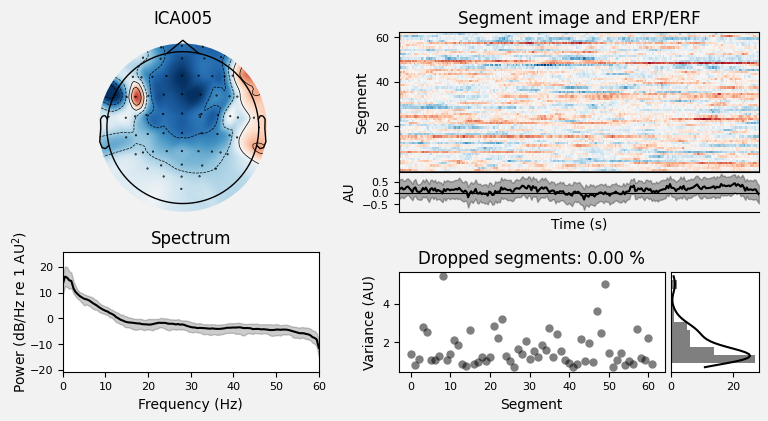

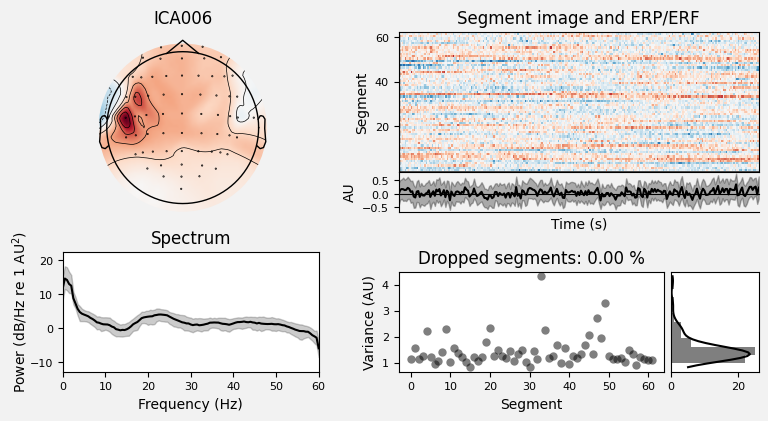

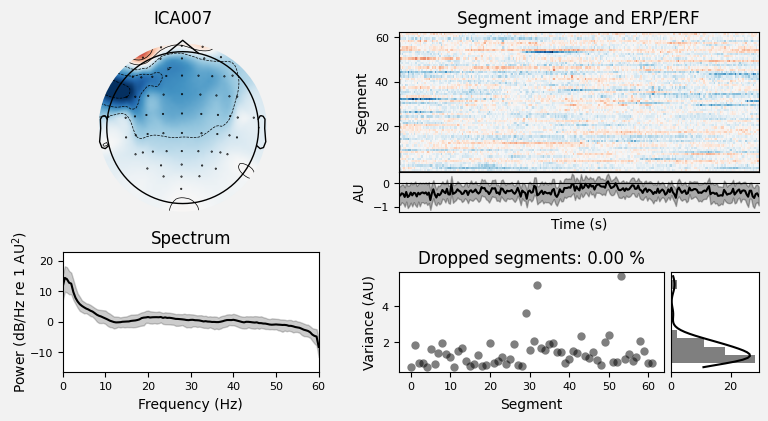

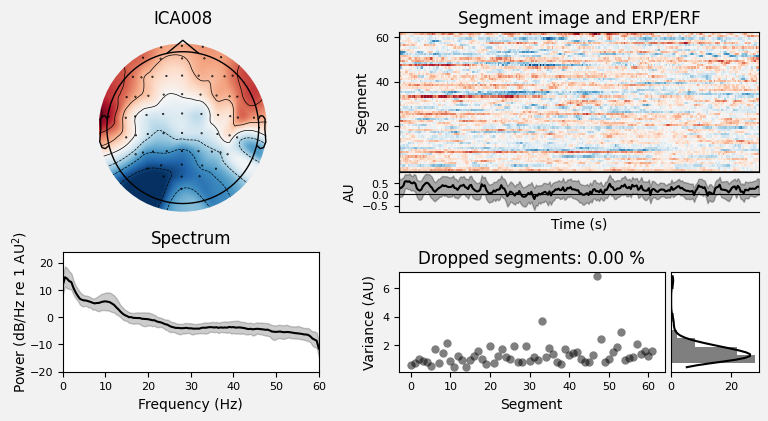

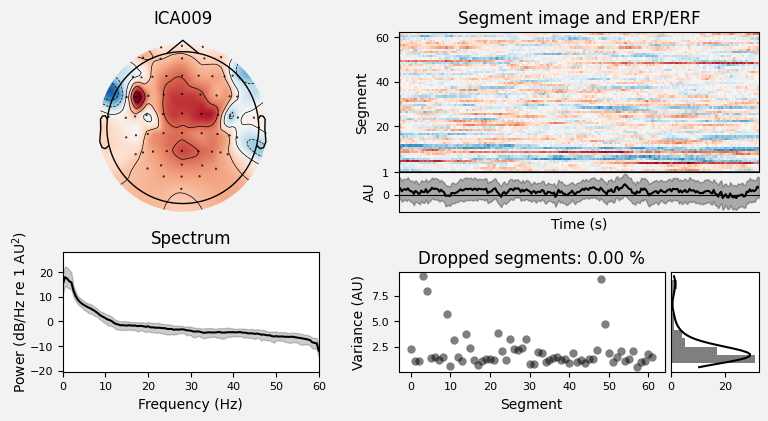

[<Figure size 800x400 with 6 Axes>,
 <Figure size 800x400 with 6 Axes>,
 <Figure size 800x400 with 6 Axes>,
 <Figure size 800x400 with 6 Axes>,
 <Figure size 800x400 with 6 Axes>]

In [16]:
ica_20.plot_properties(raw, picks=range(5,10), figsize=(8,4))

Visual comparison with original signal if major artifacts are reduced without distorting the brain signals:

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


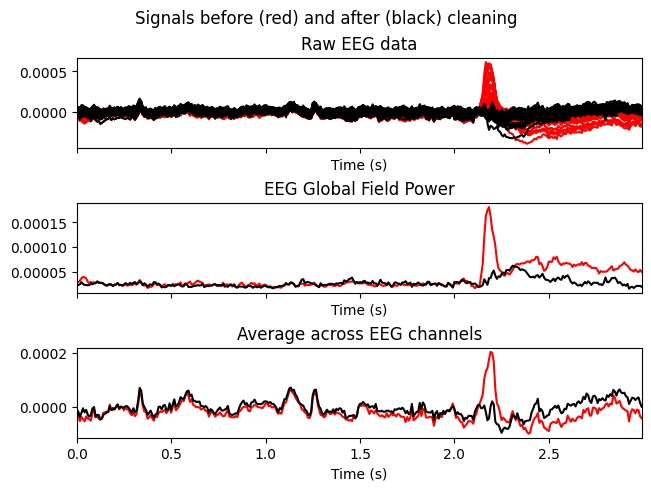

In [19]:
ica_20.plot_overlay(raw, exclude=[0]);

Middle plot (GFP) highlights many electrodes syncronized (blinks, muscle). Removing the ICA000 ocular component the large blink-related peak became greatly reduced, which indicates that ocular artifacts were effectively attenuated, though small reductions outside the peak may slightly influence underlying brain activity.

Bottom plot is channel-average for quick QC to check if ICA removed major artifacts without affecting brain signals.

In [20]:
raw_post_ica = ica_20.apply(raw.copy(), exclude=[0])

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


Created a cleaned version of the original EEG (raw_post_ica) where the identified artifact component ICA000 has been removed.

**5. Epoching**

In [21]:
from mne import Epochs, find_events

In [22]:
events, event_id = mne.events_from_annotations(raw_post_ica)
print(event_id)

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
{np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


As was determined;

T0 → rest → 1

T1 → onset of real motion of the left fist → 2

T2 → onset of real motion of the right fist → 3

In [23]:
epochs = mne.Epochs(raw_post_ica, events, event_id={'T0': 1,'T1': 2, 'T2': 3},
                    tmin=-0.2, tmax=1.0, baseline=(-0.2, 0), preload=True, reject_by_annotation=True)

Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 145 original time points ...
1 bad epochs dropped


I segmented raw_post_ica into time windows around each event (T0–T2), applied baseline correction from -0.2 s to 0, and automatically rejects epochs with artifacts.

Timescale of −0.2 s to 1 s was chosen for plots to capture motor preparation and execution (in literature commonly 300–500 ms).

Important note: The baseline period for each epoch was defined as -0.2 to 0 s before the event. Due to the rapid serial task design, this pre-event baseline may contain residual neural activity from the preceding trial, especially for Rest epochs (T0), since they are preceded by left / right hand movement. Therefore, the baseline is not a pure resting state, and ERD/ERP values should be interpreted as relative to immediate pre-event brain state, not absolute rest.

**6. Time-Frequency Analysis (ERSP)**

For motor movement, Mu and Beta rhythm frequency bands are often analyzed together as the "sensorimotor rhythm" (8-30 Hz).

Mu rhythm: ~8-13 Hz (overlaps with the alpha band, but specific to sensorimotor cortex, whereas standard "alpha" refers to the rhythm over the occipital cortex at rest), mu = "motor unit".

Beta rhythm: ~13-30 Hz.

Both show Event-Related Desynchronization (ERD) during movement and Event-Related Synchronization (ERS) after movement.

H1 - I hypothesize that brain waves in the "mu/beta" band (8-30 Hz) will decrease more during movement than at rest (Event-Related Desynchronization).

In [24]:
freqs = np.logspace(np.log10(4), np.log10(40), 20)
n_cycles = freqs / 2

I used np.logspace function for logarithmic spacing, to better represent lower frequencies. For the parameters I have chosen the range of 4 Hz - 40 Hz and 20 frequency points.

n_cycles = freqs / 2, to keep ~0.5s window for all frequencies.

I will now be measuring oscillatory power of each frequency at every moment in time for every channel using using the Morlet-wavelet function:

In [25]:
from mne.time_frequency import tfr_morlet

power_T0 = epochs['T0'].compute_tfr(
    method='morlet',
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=False,
    average=True
)

power_T1 = epochs['T1'].compute_tfr(
    method='morlet',
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=False,
    average=True
)

power_T2 = epochs['T2'].compute_tfr(
    method='morlet',
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=False,
    average=True
)

In [26]:
power_T0.apply_baseline((-0.2, 0), mode='logratio')
power_T1.apply_baseline((-0.2, 0), mode='logratio')
power_T2.apply_baseline((-0.2, 0), mode='logratio')

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


<Average Power Estimates from Epochs (nave=8), morlet method | 64 channels × 20 freqs × 145 times, 4.0 - 40.0 Hz, -0.20 - 1.00 s, 1.5 MiB>

I will now be plotting time frequency plots for T0 / T1 / T2. Based on the established literature, ERD appears to be typically in mu/beta frequencies during motor tasks, primarily over sensorimotor channels C3 and C4, which are selected here (contralateral to the moving hand); I will also be limiting the time and space dimensions where effect is expected.

Based on the H1 hypothesis, the left and right hand plots should have clear blue areas (ERD) in the beta band (13-30 Hz) after time 0, while the rest plot should not:

No baseline correction applied
No baseline correction applied
No baseline correction applied


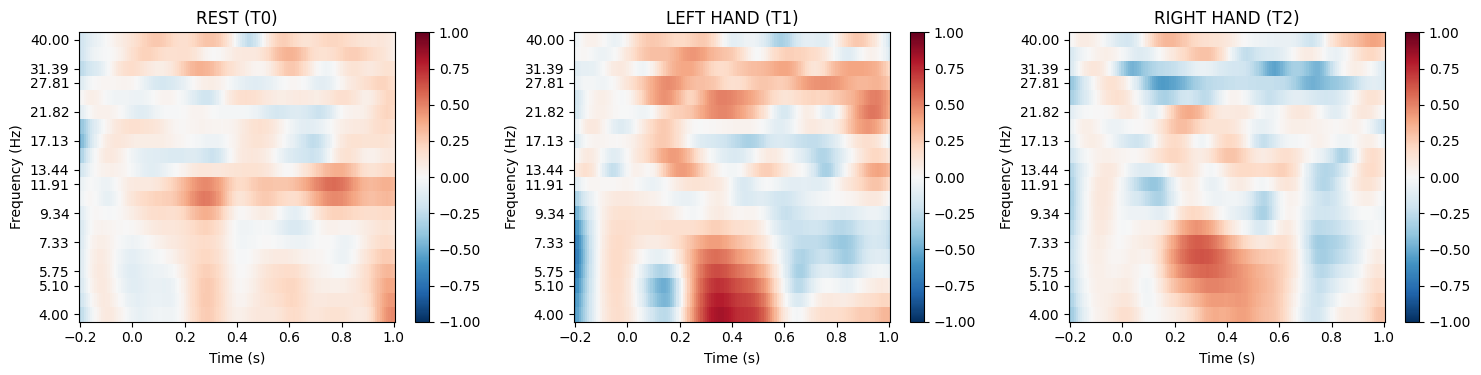

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# REST
power_T0.plot(picks=['C3','C4'], axes=axes[0], combine='mean', show=False, vlim=(-1, 1))
axes[0].set_title('REST (T0)')

# LEFT HAND
power_T1.plot(picks='C4', axes=axes[1], show=False, vlim=(-1, 1))
axes[1].set_title('LEFT HAND (T1)')

# RIGHT HAND
power_T2.plot(picks='C3', axes=axes[2], show=False, vlim=(-1, 1))
axes[2].set_title('RIGHT HAND (T2)')

plt.tight_layout()
plt.show()

Time-frequency analysis of left- and right-hand movements reveals partial and weak alignment with the expected mu/beta event-related desynchronization (ERD) pattern. For the left-hand movement, red block at 4–10 Hz between ~0.2-0.6s post-stimulus is not the expected H1 effect, while decreases in the beta range (13-30 Hz) were weak. For the right-hand movement, a similar low-frequency power increase occurred between ~0.2-0.4s, accompanied by scattered, moderate beta desynchronization (blue pixels) between ~25-30 Hz, but the signal appears weak overall.

In [28]:
freq_mask = (freqs >= 8) & (freqs <= 30)
time_mask = (power_T0.times >= 0.2) & (power_T0.times <= 1.0)

c3_idx = power_T0.ch_names.index('C3')
c4_idx = power_T0.ch_names.index('C4')

Interval of -0.2 to 1.0s was chosen for visual plots, to capture both baseline and movement, while 0.2 to 1.0s was chosen for statistics as it focuses only on movement period.

Quantifying power values for C3 and C4 electrodes for T0 / T1 / T2, for the selected frequency band and time window, and calculating the average ERD strength:

In [29]:
erd_T0_C3 = np.mean(power_T0.data[c3_idx][freq_mask][:, time_mask])
erd_T0_C4 = np.mean(power_T0.data[c4_idx][freq_mask][:, time_mask])
erd_T1_left_C4 = np.mean(power_T1.data[c4_idx][freq_mask][:, time_mask])
erd_T2_right_C3 = np.mean(power_T2.data[c3_idx][freq_mask][:, time_mask])

I will now combine left and right hand movement into one “movement” variable, and do the same for the same electrodes during rest trials.

If H1 is correct, then movement_strength should be lower than rest_strength, since more negative amplitude would result in stronger ERD.

In [30]:
movement_strength = np.mean([erd_T1_left_C4, erd_T2_right_C3])

rest_strength = np.mean([erd_T0_C4, erd_T0_C3])

difference = movement_strength - rest_strength

In [31]:
print(f"Movement ERD: {movement_strength:.3f} dB")
print(f"Rest ERD:     {rest_strength:.3f} dB")
print(f"Difference:   {difference:.3f} dB")

Movement ERD: 0.030 dB
Rest ERD:     0.104 dB
Difference:   -0.075 dB


Results show that movement ERD is 0.030 dB, rest ERD is 0.104 dB, and their difference is -0.075 dB, which shows more negative log-ratio, so slightly stronger desynchronization during movement than at rest.

The general direction of effects matches the hypothesis (movement < rest), but the magnitude is too small to be meaningful, likely because of a single subject and small number of trials averaged. With more trials/subjects, we would expect to see more significant suppression effect.

**7. Evoked Responses Analysis (ERP)**

H2 tests whether motor execution (T1/T2) produces:

1. Stronger evoked response over sensorimotor cortex than rest (T0)

2. Whether this response is lateralized, Contralateral vs Ipsilateral (lateralization).



This breaks into two tests:

1. Movement vs Rest: Are movement ERPs stronger than rest?

2. Contralateral vs Ipsilateral: Is the response stronger on the opposite side of the brain?

In [32]:
evoked_rest = epochs['T0'].average()
evoked_left = epochs['T1'].average()
evoked_right = epochs['T2'].average()

Creating an average for each of the 64 channels separately and averageing across trials for each channel.

Plotting the averaged EEG voltage across all 64 channels during rest, right hand and left hand trials to visualize activity patterns.

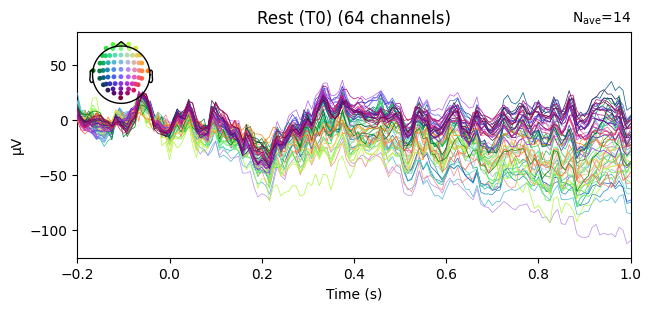

In [33]:
common_ylim_rest = dict(eeg=(-125, 80))
evoked_r = evoked_rest.plot(spatial_colors=True, time_unit='s', titles='Rest (T0)', ylim=common_ylim_rest, show=False)
evoked_r.show()

The ERP plot for rest shows low-amplitude signals with lines initially overlapping (baseline), then gradually diverging which might reflect weak or unsynchronized channel responses. Time is -0.2 to 1 s around the event, and amplitude ranges from -120 to 25 µV.

-125 µV is likely just one noisy channel; most channels stay within ±50 µV. The extreme value could be minor noise or a channel with different sensitivity.

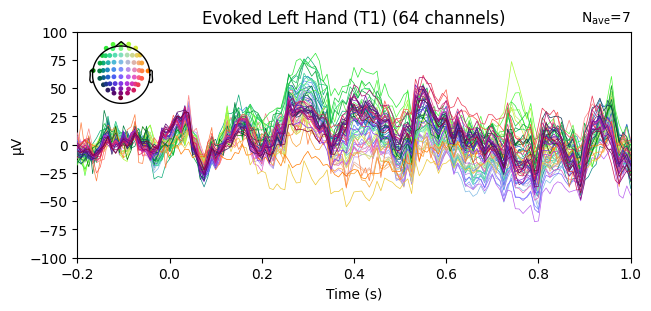

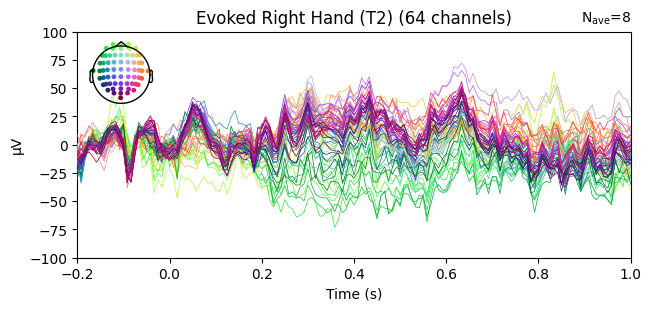

In [34]:
common_ylim_movement = dict(eeg=(-100, 100))
evoked_left_plot = evoked_left.plot(spatial_colors=True, time_unit='s', titles='Evoked Left Hand (T1)', ylim=common_ylim_movement)
evoked_left_plot.show()

evoked_right_plot = evoked_right.plot(spatial_colors=True, time_unit='s', titles='Evoked Right Hand (T2)', ylim=common_ylim_movement)
evoked_right_plot.show()

The ERP plots for left- and right-hand movements indicate peaking of amplitude within ~0.25-0.5 s (left) and ~0.2-0.6 s (right) post-movement. In those respective periods, left-hand movement appears to produce a dominant positive deflection while right-hand movement yields an elongated negative peak. Approximately 40 channels for both hands exhibit highly consistent voltage trajectories (purple). Remaining channels show spatial variability due to distance from the motor cortex and local dipole orientations. Peak amplitudes across channels range ~−75 to +75 µV.

Additonaly, small depolarization of ~−25µV is observed from 0.3 - 0.5 s in the left hand, with channels corresponding to the right central hemisphere, which may reflect a genuine motor-related cortical response. The expected pattern was both left and right hand movements producing negative voltage deflections over the contralateral motor cortex.

I will now be plotting voltage topography maps to visualize the spatial distribution of brain activity at specific time points (300ms and 500ms) after movement onset:

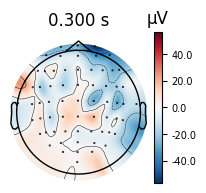

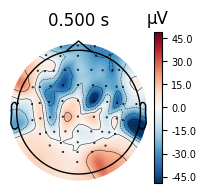

In [45]:
evoked_rest_eeg = evoked_rest.copy().pick('eeg', exclude=[])
for t in [0.3, 0.5]:
    evoked_rest_eeg.plot_topomap(
        times=[t],
        ch_type='eeg',
        show=True,
        colorbar=True,
        size=1.3
    )

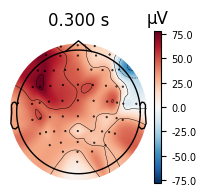

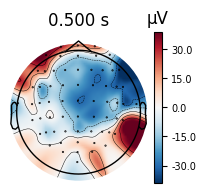

In [46]:
evoked_left_eeg = evoked_left.copy().pick('eeg', exclude=[])
for t in [0.3, 0.5]:
    evoked_left_eeg.plot_topomap(
        times=[t],
        ch_type='eeg',
        show=True,
        colorbar=True,
        size=1.3
    )

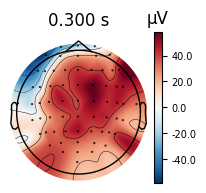

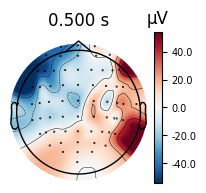

In [47]:
evoked_right_eeg = evoked_right.copy().pick('eeg', exclude=[])
for t in [0.3, 0.5]:
    evoked_right_eeg.plot_topomap(
        times=[t],
        ch_type='eeg',
        show=True,
        colorbar=True,
        size=1.3
    )

Topography maps showed the expected contralateral organization. Early positivity ~300 ms appeared ipsilaterally, followed by robust contralateral negativity ~500 ms over the sensorimotor cortex. Ipsilateral positivity preceding contralateral negativity reflects typical motor execution sequence and confirms proper hemispheric specialization for hand movements.

Now I am extracting the average voltage for each individual trial at specific electrodes, to be able to perform statistical tests comparing contralateral vs ipsilateral activation trial-by-trial, rather than just looking at averaged waveforms.

In [38]:
tmin_motor, tmax_motor = 0.3, 0.6

epochs_left = epochs['T1']
epochs_right = epochs['T2']

In [39]:
def avg_amp_epoch(epochs_obj, ch_name, tmin, tmax):
    ch_idx = epochs_obj.ch_names.index(ch_name)

    cropped_data = epochs_obj.copy().crop(tmin, tmax)

    data_array = cropped_data.get_data()

    mean_amps = data_array[:, ch_idx, :].mean(axis=1)

    return mean_amps

C4 is located in the right hemisphere and, according to this hypothesis, is expected to exhibit stronger motor-related activity as it is contralateral to the left hand, whereas C3 is located in the left hemisphere and is ipsilateral.

Extracting amplitude of both C3 and C4 for each hand:

In [40]:
# Left-hand:
T1_C4_amp = avg_amp_epoch(epochs['T1'], 'C4', tmin_motor, tmax_motor)
T1_C3_amp = avg_amp_epoch(epochs['T1'], 'C3', tmin_motor, tmax_motor)

# Right-hand:
T2_C3_amp = avg_amp_epoch(epochs['T2'], 'C3', tmin_motor, tmax_motor)
T2_C4_amp = avg_amp_epoch(epochs['T2'], 'C4', tmin_motor, tmax_motor)

Left hand: Is C4 more negative in amplitude than C3 at a statistically significant level (α = 0.05)?

In [41]:
from scipy import stats
print(f"\nLeft Hand Movement (T1):")
t_left, p_left = stats.ttest_rel(T1_C4_amp, T1_C3_amp)

print(f"  C4 (contralateral) vs C3 (ipsilateral)")
print(f"  t({len(T1_C4_amp)-1}) = {t_left:.3f}, p = {p_left:.4f}")
if p_left < 0.05:
    print("Significant: C4 is more negative than C3")
else:
    print("Not significant")


Left Hand Movement (T1):
  C4 (contralateral) vs C3 (ipsilateral)
  t(6) = -0.941, p = 0.3831
Not significant


Right hand: Is C3 more negative in amplitude than C4 at a statistically significant level (α = 0.05)?

In [42]:
print(f"\nRight Hand Movement (T2):")
t_right, p_right = stats.ttest_rel(T2_C3_amp, T2_C4_amp)

print(f"  C3 (contralateral) vs C4 (ipsilateral)")
print(f"  t({len(T2_C3_amp)-1}) = {t_right:.3f}, p = {p_right:.4f}")
if p_right < 0.05:
    print("Significant: C4 is more negative than C3")
else:
    print("Not significant")


Right Hand Movement (T2):
  C3 (contralateral) vs C4 (ipsilateral)
  t(7) = 0.545, p = 0.6024
Not significant


Paired t-tests showed no significant difference between contralateral and ipsilateral electrodes for either left-hand (C4 vs C3, p = 0.38) or right-hand movements (C3 vs C4, p = 0.60).

The left-hand condition showed a trend in the expected contralateral direction (t(6) = -0.941), but the effect was weak and highly variable likely from limited statistical power.

Quantifying effect size using Cohen's d:

In [43]:
# Left-hand
diff_left = T1_C4_amp - T1_C3_amp
cohens_d_left = np.mean(diff_left) / np.std(diff_left, ddof=1)
print(f"Cohen's d for Left Hand (C4-C3): {cohens_d_left:.3f}")

# Right-hand
diff_right = T2_C3_amp - T2_C4_amp
cohens_d_right = np.mean(diff_right) / np.std(diff_right, ddof=1)
print(f"Cohen's d for Right Hand (C3-C4): {cohens_d_right:.3f}")

Cohen's d for Left Hand (C4-C3): -0.356
Cohen's d for Right Hand (C3-C4): 0.193


Effect size analysis showed a small contralateral effect for left-hand movements (Cohen’s d = −0.37) which indicates more negative amplitudes at C4 than C3 and in the expected direction, though the effect was not robust given the limited number of trials.

For right-hand movements, the effect size was negligible (d = 0.10) and opposite to the expected direction.

**Results:**

Overall, the findings appear mixed and inconsistent:


ERD Results:

1. Time-frequency plots showed weak ERD with unexpected low-frequency power increases rather than the expected desynchronization.

2. ERD quantification comparing movement and rest strength revealed negligible difference (-0.075 dB).


ERP Results:

3. ERP waveforms suggested a potential polarity difference; prominent green traces in left-hand responses appearing more positive and right-hand negative.

4. Topographic maps for T1 and T2 displayed the expected contralateral pattern at 500 ms.

5. Paired t-tests and Cohen's d value found no statistically significant lateralization (all p > 0.05), with mixed effect sizes across hands.

In order to be able to draw any meaningful inferential statistic, multi-subject analysis would be required, which would provide the statistical power necessary.

**Limitations:**

This analysis is based on a single subject and a single run, using within-subject, within-run averaging of ERSP/ERD and ERP measures. No group-level statistics are possible, and the results only demonstrate patterns observed in this subject.

Comparisons between Movement (T1/T2) and Rest (T0) may be affected by baseline contamination. The Rest condition may include residual activity from previous movements, so ERD/ERP differences reflect contrasts relative to the immediate pre-event state rather than a true neutral baseline.

The results do not provide statistically robust evidence for contralateral motor activation due to the small number of trials, but they show trends consistent with expected hemispheric patterns.